#Import Library

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import re
import string

In [24]:
pip install imbalanced-learn

#Memuat Dataset

In [2]:
# Memuat dataset
df = pd.read_csv('shopee_reviews_filtered.csv')

# Menampilkan informasi dasar dataset
print("Jumlah baris dan kolom:")
print(df.shape)

# Menampilkan tipe data dari setiap kolom
print("\nInformasi kolom:")
print(df.info())

# Menampilkan 5 baris pertama dataset
print("\n5 baris pertama dataset:")
print(df.head())

Jumlah baris dan kolom:
(4355, 3)

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  4340 non-null   object
 1   rating    4355 non-null   int64 
 2   comment   4355 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.2+ KB
None

5 baris pertama dataset:
          username  rating                                            comment
0  muhammadjuandra       5  Tampilan:ok banget cantik banget\nKualitas:ok ...
1   alvaro.maulana       5  Tampilan:Keren\nKualitas:bagus banget\nPerform...
2    nurhayati2607       5  Tampilan:Tampilan Bagus sekali, tidak tipis\nK...
3          i*****4       5  Kualitas:Bagus\nPerforma:Bagus\nTampilan:Bagus...
4     ziesuno70411       5  Tampilan:bagua sesuai foto\nPerforma:belum dip...


In [3]:
# Cek nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
username    15
rating       0
comment      0
dtype: int64


In [4]:
# Cek distribusi rating
print("\nDistribusi rating:")
print(df['rating'].value_counts())


Distribusi rating:
rating
5    2128
3     814
4     521
1     504
2     388
Name: count, dtype: int64


#Data Preprocessing

####Cek Data Missing

In [5]:
# Menangani data yang hilang pada kolom 'username'
df_cleaned = df.dropna(subset=['username'])
print(df_cleaned.isnull().sum())

username    0
rating      0
comment     0
dtype: int64


####Text Cleaning

In [6]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_comment'] = df['comment'].apply(clean_text)

####Labeling Sentimen

In [7]:
# Menentukan label sentimen
def get_sentiment(text):
    from textblob import TextBlob
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['cleaned_comment'].apply(get_sentiment)

#Data Preparation

In [8]:
# Encode label
y = LabelEncoder().fit_transform(df['label'])
X = df['cleaned_comment']

# Pisahkan data menjadi train dan test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Eksperimen dengan 3 Skema Pelatihan

####Skema 1: SVM dengan TF-IDF(80/20 split)

In [9]:
# Preprocessing untuk model berbasis TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# Terapkan SMOTE hanya pada data pelatihan
smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("Distribusi label setelah SMOTE:", Counter(y_train_smote))

Distribusi label setelah SMOTE: Counter({1: 3047, 2: 3047, 0: 3047})


In [17]:
# Eksperimen dengan 3 skema pelatihan (model)
# 1. Model SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf_smote, y_train_smote)
y_pred_svm = svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nEvaluasi Model SVM:")
print(f"Accuracy: {accuracy_svm}")
print(classification_report(y_test, y_pred_svm, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model SVM:
Accuracy: 0.9701492537313433
              precision    recall  f1-score   support

     negatif       0.89      0.47      0.62        17
      netral       0.97      1.00      0.98       761
     positif       0.98      0.85      0.91        93

    accuracy                           0.97       871
   macro avg       0.94      0.77      0.84       871
weighted avg       0.97      0.97      0.97       871



####Skema 2: Random Forest dengan Word2Vec (80/20 split)

In [18]:
# 2. Model Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nEvaluasi Model Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model Random Forest:
Accuracy: 0.8978185993111366
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        17
      netral       0.90      1.00      0.94       761
     positif       0.92      0.25      0.39        93

    accuracy                           0.90       871
   macro avg       0.61      0.41      0.44       871
weighted avg       0.88      0.90      0.87       871



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


####Skema 3: Deep Learning LSTM (70/30 split)

In [12]:
# Preprocessing untuk model LSTM
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Konversi label ke one-hot encoding
y_train_cat = pd.get_dummies(y_train).values
y_test_cat = pd.get_dummies(y_test).values

In [19]:
# 3. Model LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(128, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.5),
    LSTM(64, kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

history = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callbacks
)

loss, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test_cat)
print("\nEvaluasi Model LSTM:")
print(f"Accuracy: {accuracy_lstm}")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 476ms/step - accuracy: 0.8172 - loss: 3.0924 - val_accuracy: 0.8737 - val_loss: 1.1094 - learning_rate: 0.0010
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.8787 - loss: 0.9242 - val_accuracy: 0.8737 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.8681 - loss: 0.5116 - val_accuracy: 0.8852 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.9292 - loss: 0.2702 - val_accuracy: 0.9162 - val_loss: 0.3521 - learning_rate: 0.0010
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9578 - loss: 0.1945 - val_accuracy: 0.9277 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - accuracy: 0.9653 - loss: 0.1554 - val_accuracy: 0.9334 - val_loss: 0.3628 - learning_rate: 0.0010
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.9710 - loss: 0.1349 - val_

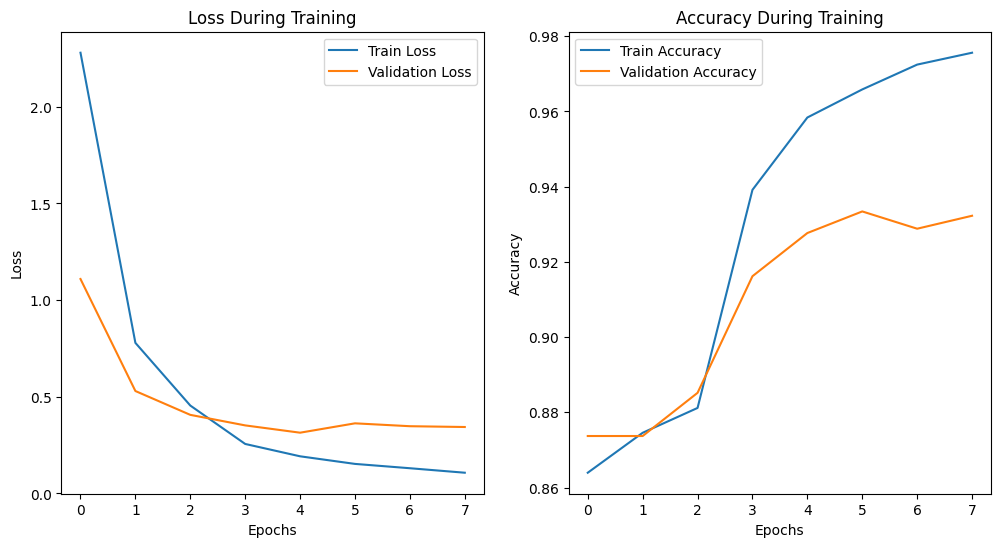

In [20]:
# Visualisasi hasil
import matplotlib.pyplot as plt

# Plot loss dan akurasi selama pelatihan
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Testing

In [21]:
# Bandingkan akurasi ketiga model
accuracies = {'SVM': accuracy_svm, 'Random Forest': accuracy_rf, 'LSTM': accuracy_lstm}

best_model_name = max(accuracies, key=accuracies.get)
print("\nModel terbaik berdasarkan akurasi:", best_model_name)


Model terbaik berdasarkan akurasi: SVM


In [23]:
# Gunakan instance LabelEncoder yang telah dilatih sebelumnya
le = LabelEncoder()
le.fit(df['label'])  # Pastikan LabelEncoder dilatih pada label asli di dataset

# Pilih model terbaik untuk prediksi
if best_model_name == 'SVM':
    best_model = svm
    best_predictions = y_pred_svm
elif best_model_name == 'Random Forest':
    best_model = rf
    best_predictions = y_pred_rf
else:
    best_model = model_lstm
    best_predictions = model_lstm.predict(X_test_pad).argmax(axis=1)

# Perbandingan label asli dan prediksi
comparison_df = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(best_predictions)
})
print("\nPerbandingan Label Asli dan Prediksi dengan Model Terbaik:")
print(comparison_df.head())


Perbandingan Label Asli dan Prediksi dengan Model Terbaik:
    Actual Predicted
0   netral    netral
1   netral    netral
2  positif   positif
3   netral    netral
4   netral    netral


In [ ]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.9
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.2.0.35.34
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.27.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.